In [18]:
from __future__ import annotations

import json
import os
import re
from pathlib import Path
from typing import (
    Any,
    Union,  # noqa: F401
)
import random
import numpy as np
import pandas as pd
import anndata as ad
from scanpy import logging as logg
from scipy.sparse import csr_matrix
from sklearn import neighbors
import squidpy as sq
import scanpy as sc
import scipy

from squidpy._constants._pkg_constants import Key
from squidpy.datasets._utils import PathLike
from squidpy.read._utils import _load_image, _read_counts


import sys

sys.path.append('/home1/2254704l/unroll_package')

import unroll_package_functions as unroll

In [19]:
#Notes for running successfully:

#The unlabelled spots are important for splitting up the intestine into sections, as such you need to make sure that the unlabelled spots of different sections don't overlap
#Seperate them by drawing a basement spot line inbetween



In [20]:
day7_visium = unroll.visium("/datastore3/RossOlympia/Day7_seperatePackageTest/outs", counts_file="filtered_feature_bc_matrix.h5", library_id = "Day7")
day7_visium.obs["total_counts"] = np.sum(day7_visium.X, axis = 1)
day7_visium.var_names_make_unique()

#Load in location IDs
location_id = pd.read_csv("/datastore3/RossOlympia/Day7_seperatePackageTest/MyAnnotationsWithBlanks_v7.csv", index_col = 0)
day7_visium.obs["location"] = location_id
day7_visium.obs["spot_id"] =  day7_visium.obs.index

basement_id = pd.read_csv("/datastore3/RossOlympia/Day7_seperatePackageTest/basement_upper.csv", index_col = 0)
day7_visium.obs["basement_layer"] = basement_id
# sq.pl.spatial_scatter(day7_visium, color = "basement_layer")

basement_id = pd.read_csv("/datastore3/RossOlympia/Day7_seperatePackageTest/centre.csv", index_col = 0)
day7_visium.obs["centre"] = basement_id
# sq.pl.spatial_scatter(day7_visium, color = "centre")

day7_visium.obs['location'] = day7_visium.obs['location'].replace({np.nan:"unlabelled"})

day7_visium.obs['location']=day7_visium.obs['location'].astype('str').astype('category')

day7_visium.obs['location']= day7_visium.obs['location'].cat.rename_categories(['Crypts', 'Granuloma', 'Villi', 'Worm', 'unlabelled'])

day7_visium.obs['basement_layer']=day7_visium.obs['basement_layer'].astype('str').astype('category')


day7_visium.obs["basement_layer"]=day7_visium.obs["basement_layer"].cat.add_categories(['unlabelled'])
day7_visium.obs["basement_layer"][day7_visium[day7_visium.obs['location'] == "unlabelled" ].obs.index] = "unlabelled"

day7_visium.obs['basement_layer']=day7_visium.obs['basement_layer'].astype('str').astype('category')

day7_visium.obs['basement_layer']= day7_visium.obs['basement_layer'].cat.rename_categories(['basement', 'unlabelled', 'upper'])


/home1/2254704l/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [21]:
day7_visium

# sq.pl.spatial_scatter(day7_visium, color = "basement_layer")
# sq.pl.spatial_scatter(day7_visium, color = "location")


AnnData object with n_obs × n_vars = 4992 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'total_counts', 'location', 'spot_id', 'basement_layer', 'centre'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

/home1/2254704l/unroll_package/unroll_package_functions.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_out["graph_cluster"].iloc[current_index] = str(counter)
/home1/2254704l/unroll_package/unroll_package_functions.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_out["graph_cluster"].iloc[current_index] = str(counter)
/home1/2254704l/unroll_package/unroll_package_functions.py:328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

AnnData object with n_obs × n_vars = 3964 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'total_counts', 'location', 'spot_id', 'basement_layer', 'centre', 'sections'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'sections_colors'
    obsm: 'spatial'

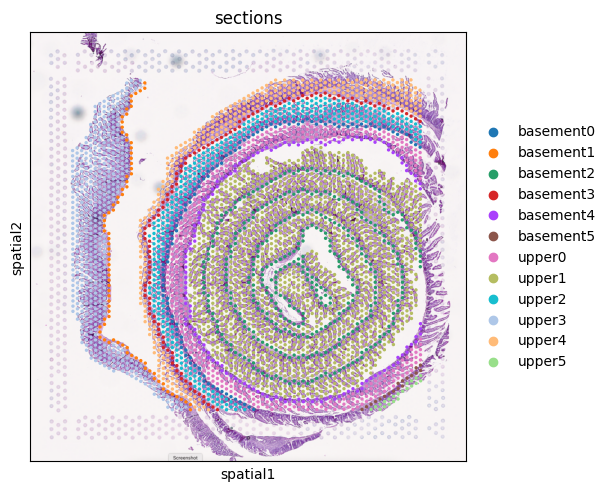

In [22]:
day7_visium_sections = unroll.seperate_sections(day7_visium, obs_column = "location", spatial_name = "spatial", nn_radius = 34)
sq.pl.spatial_scatter(day7_visium_sections, color = "sections")
day7_visium_sections

In [23]:
centre_coordinates = day7_visium_sections[day7_visium_sections.obs['centre'] == "centre"].obsm['spatial']

match_df = unroll.match_and_merge(day7_visium_sections, centre_coordinates = centre_coordinates,basement_inside = True )

In [24]:
match_df

upper   basement
0  upper0  basement4
1  upper1  basement2
2  upper2  basement0
3  upper3  basement1
4  upper4  basement3
5  upper5  basement5

In [25]:

adjustedSpatial_datasets = unroll.getNewSpatial(day7_visium_sections, match_df)



/home1/2254704l/unroll_package/unroll_package_functions.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_dist_df[upper][basement] = distance_result


Lineages: [Lineage[4, 3, 5, 6, 2, 7, 1, 0]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.28it/s]


Reversing from leaf to root
Lineages: [Lineage[5, 4, 3, 2, 1, 0]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.35it/s]

Reversing from leaf to root



/home1/2254704l/unroll_package/unroll_package_functions.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_dist_df[upper][basement] = distance_result


Lineages: [Lineage[13, 11, 4, 7, 14, 15, 6, 3, 1, 5, 9, 0, 12, 10, 8, 2]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Reversing from leaf to root
Lineages: [Lineage[8, 7, 9, 6, 5, 3, 4, 1, 0, 2, 10]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]

Reversing from leaf to root



/home1/2254704l/unroll_package/unroll_package_functions.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_dist_df[upper][basement] = distance_result


Lineages: [Lineage[4, 2, 1, 3, 0, 6, 5]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Reversing from leaf to root
Lineages: [Lineage[0, 2, 1, 3, 5, 6, 4]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.14it/s]


Reversing from leaf to root


/home1/2254704l/unroll_package/unroll_package_functions.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_dist_df[upper][basement] = distance_result


Lineages: [Lineage[5, 0, 1, 2, 3, 4]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.20it/s]


Reversing from leaf to root
Lineages: [Lineage[4, 5, 0, 2, 1, 3]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.19it/s]

Reversing from leaf to root



/home1/2254704l/unroll_package/unroll_package_functions.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_dist_df[upper][basement] = distance_result


Lineages: [Lineage[3, 4, 2, 0, 5, 6, 1]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Reversing from leaf to root
Lineages: [Lineage[0, 1, 5, 4, 3, 2]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.59it/s]


Reversing from leaf to root


/home1/2254704l/unroll_package/unroll_package_functions.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_dist_df[upper][basement] = distance_result


Lineages: [Lineage[1, 0]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 261.28it/s]


Reversing from leaf to root
Lineages: [Lineage[1, 2, 0]]


  0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/home1/2254704l/.local/lib/python3.10/site-packages/pyslingshot/slingshot.py:329: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 339.29it/s]

Reversing from leaf to root


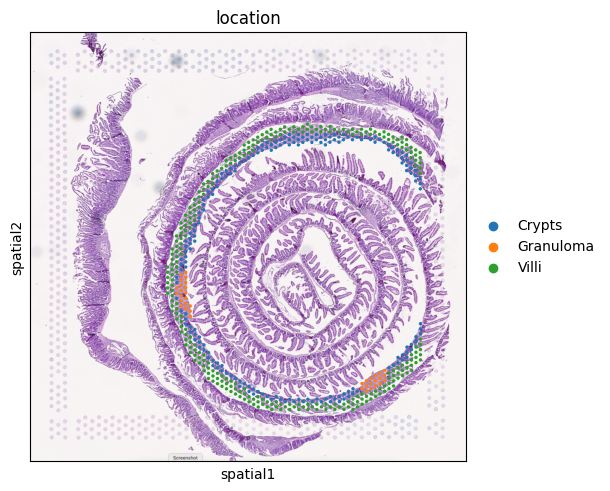

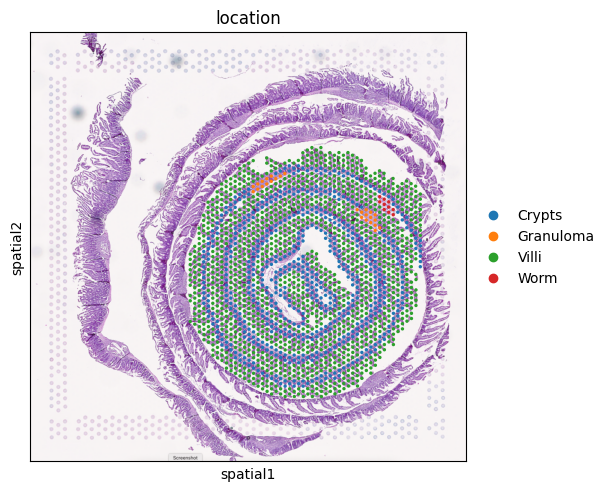

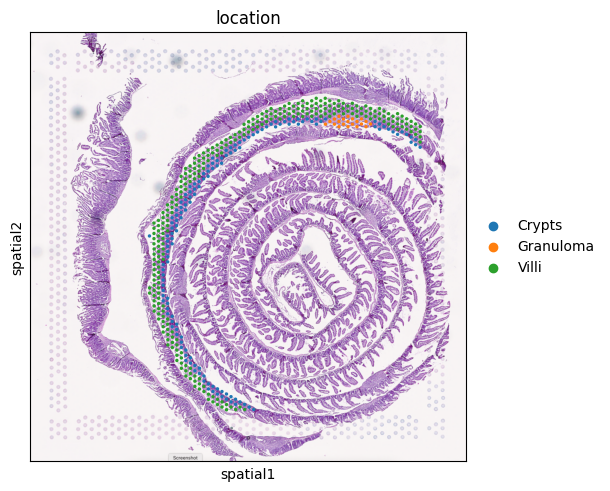

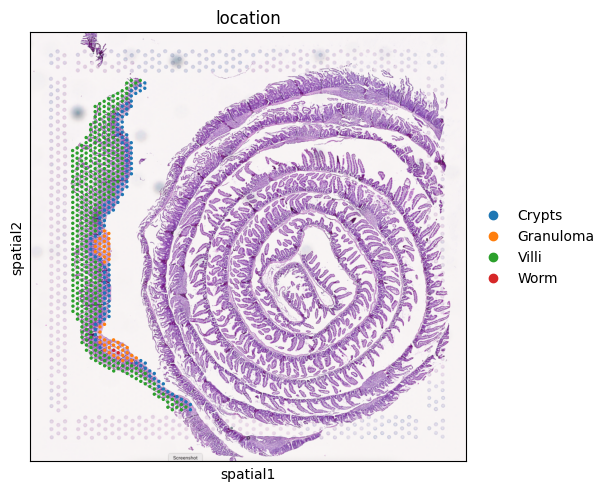

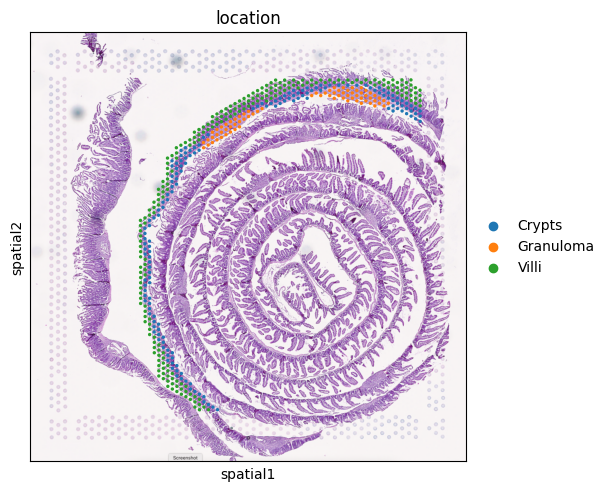

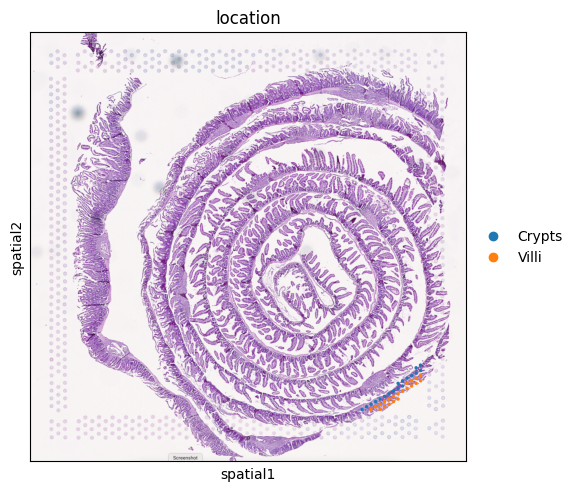

In [27]:
sq.pl.spatial_scatter(adjustedSpatial_datasets[0], color = "location")
sq.pl.spatial_scatter(adjustedSpatial_datasets[1], color = "location")
sq.pl.spatial_scatter(adjustedSpatial_datasets[2], color = "location")
sq.pl.spatial_scatter(adjustedSpatial_datasets[3], color = "location")
sq.pl.spatial_scatter(adjustedSpatial_datasets[4], color = "location")
sq.pl.spatial_scatter(adjustedSpatial_datasets[5], color = "location")


In [30]:
#Merge them together
day7_merge = ad.concat(adjustedSpatial_datasets, label = 'unrolledSections', keys = ['0', '1', '2', '3', '4', '5'],uns_merge="first")
day7_merge[day7_merge.obs['location'] != "unlabelled"].write("/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/day7_2/day7_merged_sections.h5ad")

/home1/2254704l/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home1/2254704l/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home1/2254704l/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


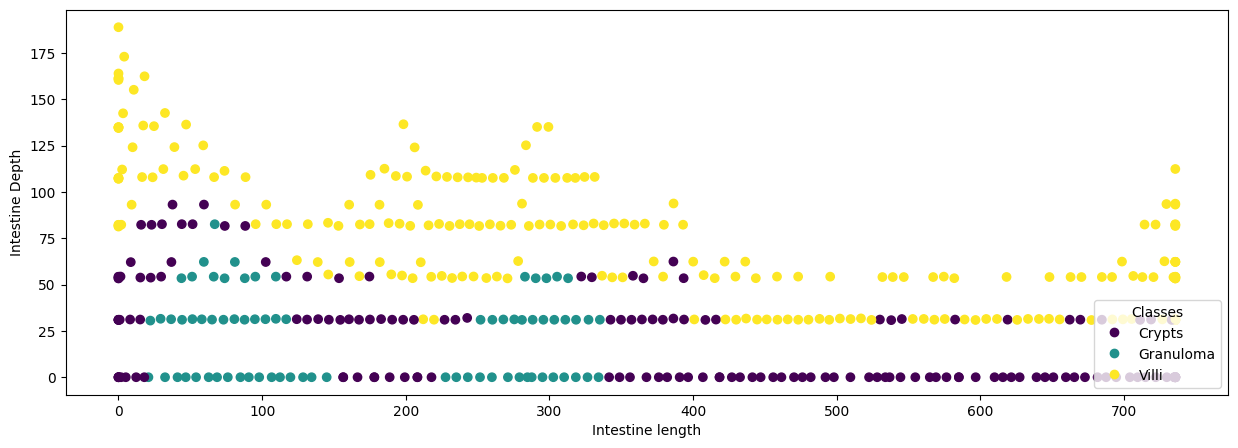

In [33]:
unroll.adjustedSpatial_scatter(adjustedSpatial_datasets[4], 'location', obsm_space = 'adjusted_spatial')

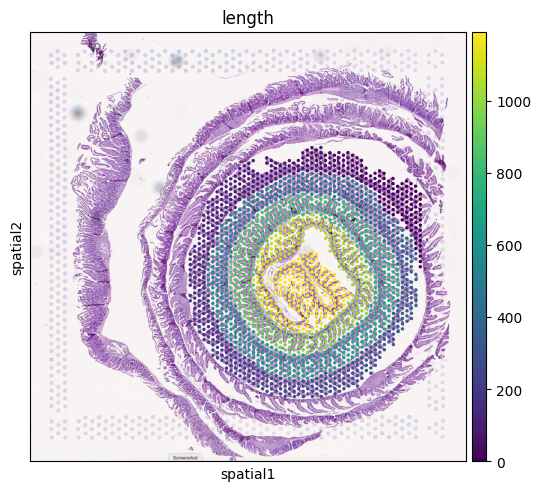

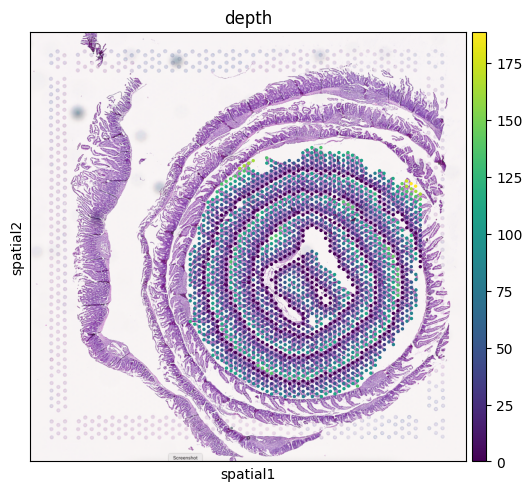

In [39]:
sq.pl.spatial_scatter(adjustedSpatial_datasets[1], color = 'length')
sq.pl.spatial_scatter(adjustedSpatial_datasets[1], color = 'depth')

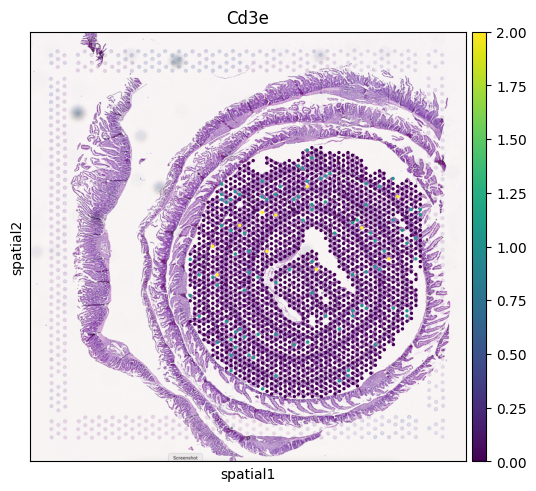

In [42]:
sq.pl.spatial_scatter(adjustedSpatial_datasets[1], color = 'Cd3e')